# Parameters

In [1]:
from globenn.model import *
import geopy
from geopy import distance
from obspy.taup import plot_travel_times
from obspy.taup import TauPyModel
from glob import glob
from scipy import spatial

# Load style
plt.style.use("../hatsyim.mplstyle")

# for reproducibility
os.environ['PYTHONHASHSEED']= '123'
np.random.seed(123)

# Hyperparameter
rec_typ = 'ISC_array'

# saving parameters
num_epo = int(2001)
num_blo = 21 #20
coo_sys = 'cartesian'
vel_sha = 'sphere'
vel_typ = 'gladm25'
num_neu = 512
lea_rat = 5e-6
act_fun = torch.nn.ELU
bat_siz = 128 #num_pts // 100
ada_wei = False
vel_sca = 1
opt_fun = torch.optim.Adam
dev_typ = "cuda"
nor_typ = "MinMax"
bac_vel = 10 #6 #10.5

offline, old = False, False

# Model parameters
params = {}
params['model_path'] = '../models/'
params['device'] = dev_typ
params['mixed_precision'] = False
params['num_blocks'] = num_blo
params['act_function'] = act_fun
params['num_points'] = 1e4
params['batch_size'] = bat_siz
params['val_percentage'] = 10
params['num_epochs'] = num_epo
params['sampling_bounds'] = [0.1,0.9]
params['log_frequency'] = 1
params['save_frequency'] = 10
params['learning_rate'] = lea_rat
params['use_scheduler'] = True
params['xmin'] = torch.tensor([-1.0001783, -1.0001783, -0.9968218])
params['xmax'] = torch.tensor([1.0001783, 1.0001783, 0.9968218])

PROJECT_NAME='subsection-1'

# Saving path
model_path = "./../saves/" + PROJECT_NAME
figures_path = model_path + '/'
checkpoints_path = figures_path + 'checkpoints' + '/'
predictions_path = figures_path + 'predictions' + '/'

from pathlib import Path

Path(figures_path).mkdir(parents=True, exist_ok=True)
Path(checkpoints_path).mkdir(parents=True, exist_ok=True)
Path(predictions_path).mkdir(parents=True, exist_ok=True)

# Data Loading

In [2]:
path_file = '/home/taufikmh/KAUST/spring_2022/global_pinns/data/glad-m25-vp-0.0-n4.nc'
data = xr.open_dataset(path_file)

offline = False
old = False

# Subsample the model along the depth, latitude, and longitude directions
if offline and old:
    dep_ini, dep_inc = 11, 4
    lat_ini, lat_inc = 0, 8
    lon_ini, lon_inc = 0, 8
else:
    dep_ini, dep_inc = 11, 1
    lat_ini, lat_inc = 0, 4
    lon_ini, lon_inc = 0, 4    

# Input variables
vpv = data.variables['vpv'].values[dep_ini::dep_inc, lat_ini::lat_inc, lon_ini::lon_inc]
vph = data.variables['vph'].values[dep_ini::dep_inc, lat_ini::lat_inc, lon_ini::lon_inc]
longitude = data.variables['longitude'].values[lon_ini::lon_inc]
latitude = data.variables['latitude'].values[lat_ini::lat_inc]
depth = data.variables['depth'].values[dep_ini::dep_inc]

dep_dim = vpv.shape[0]
lat_dim = vpv.shape[1]
lon_dim = vpv.shape[2]

# Projection
LAT, ALT, LON = np.meshgrid(latitude, -1e3*depth, longitude)
x, y, z = pm.geodetic2ecef(LAT, LON, ALT)
_, DEP, _ = np.meshgrid(latitude, depth, longitude)

# Medium Parameters

In [3]:
# Load all stations
ISCall = pd.read_csv('../data/stations.csv')
ISCall = ISCall.rename(columns={"X":"LON", 'Y':'LAT'})
ISCarray = ISCall[ISCall['description'].str.contains('to 2021')]
ISCarrLon = ISCarray['LON'][::5]
ISCarrLat = ISCarray['LAT'][::5]

USarray = pd.read_excel('../data/_US-TA-StationList.xls')
USarrLon = USarray['LON'][::1]
USarrLat = USarray['LAT'][::1]

# Concatenate the two receiver group
AllLon = np.hstack((USarrLon, ISCarrLon))
AllLat = np.hstack((USarrLat, ISCarrLat))

ear_rad = 6371
lat_sou = latitude.flat[np.abs(latitude - 33.97).argmin()]
lon_sou = longitude.flat[np.abs(longitude - 132.52).argmin()]
dep_sou = depth.flat[np.abs(depth - 47.4).argmin()]

xx = (ear_rad - DEP) * np.sin(np.radians(LAT+90)) * np.cos(np.radians(180+LON))/(1e3)
yy = (ear_rad - DEP) * np.sin(np.radians(LAT+90)) * np.sin(np.radians(180+LON))/(1e3)
zz = DEP * np.cos(np.radians(LAT+90)) / (1e3)

# coordinates setup
sx, sy, sz = pm.geodetic2ecef(lat_sou, lon_sou, -1e3*dep_sou)

# rescale
x,y,z = x/(ear_rad*1e3), y/(ear_rad*1e3), z/(ear_rad*1e3)
sx, sy, sz = sx/(ear_rad*1e3), sy/(ear_rad*1e3), sz/(ear_rad*1e3)

X,Y,Z = x,y,z

# for plotting only
x_plot,y_plot,z_plot = x.reshape(-1,1)*ear_rad/1000, y.reshape(-1,1)*ear_rad/1000, z.reshape(-1,1)*ear_rad/1000

num_pts = x.size

# sou_idx = np.where((np.isclose(x.reshape(-1,1), sx)) & (np.isclose(y.reshape(-1,1), sy)) & (np.isclose(z.reshape(-1,1), sz)))[0]
sx, sy, sz = x.flat[np.abs(x - sx).argmin()], y.flat[np.abs(y - sy).argmin()], z.flat[np.abs(z - sz).argmin()]

# define receiver coordinates
xR, yR, zR = X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1)

# define source coordinates
xS, yS, zS = sx*np.ones_like(X.reshape(-1,1)), sy*np.ones_like(X.reshape(-1,1)), sz*np.ones_like(X.reshape(-1,1))

vel_inh, vel_all, vel_gap = vpv, vpv, vpv

# define inputs and output
Xp = np.hstack((xS, yS, zS, xR, yR, zR))
yp = vel_gap.reshape(-1,1)

# input for database
Xb = np.copy(Xp)
yb = np.copy(yp)

# For plotting only
x_plot,y_plot,z_plot = x.reshape(-1,1)*ear_rad/1000, y.reshape(-1,1)*ear_rad/1000, z.reshape(-1,1)*ear_rad/1000
num_pts = x.size

# Model Loading

In [4]:
# Define model
model_path = "../saves/pre-trained/model_sub1.pt"
model = Model(params)
model.load(model_path)

# Plots

## Training Curves

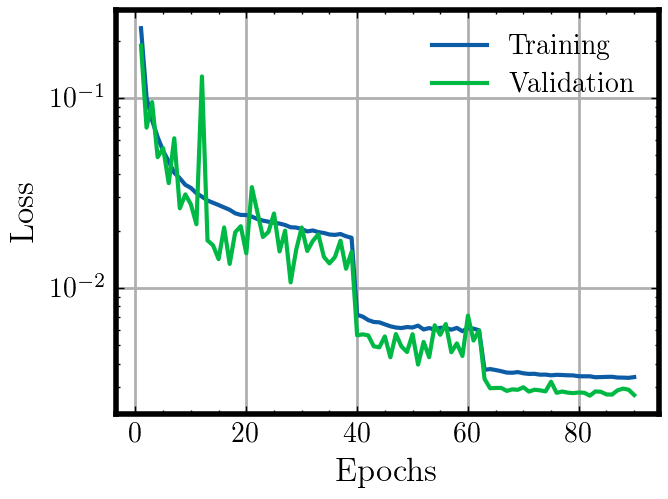

In [5]:
# convergence history plot for verification
plt.figure()
ax = plt.axes()
ax.semilogy(np.arange(len(model.total_train_loss[160:]))+1,model.total_train_loss[160:],label='Training')
ax.semilogy(np.arange(len(model.total_train_loss[160:]))+1,model.total_val_loss[160:],label='Validation')
ax.set_xlabel('Epochs')
# plt.ylim(0.0001,0)
# plt.xticks(fontsize=10)
ax.legend()
# ax.xaxis.set_major_locator(plt.MultipleLocator(500))
# plt.title('Learning Curve')
ax.set_ylabel('Loss')
# plt.yticks(fontsize=10);
plt.grid()
plt.savefig(figures_path + 'loss.pdf', bbox_inches="tight")

# Inference

In [6]:
name = '/*.h5'
dire = predictions_path
file = [i for i in os.listdir(dire) if re.search(name, i)]

if len(file) == 0:

    Xt = torch.utils.data.DataLoader(
    torch.from_numpy(Xb).to(torch.float).to(torch.device('cuda')),
    batch_size=int(Xb.shape[0]//100)
    )
    T_pred = model.traveltimes(Xt, projection=False, normalization=True).cpu().reshape(vel_all.shape)
    V_pred = model.velocity(Xt, projection=False, normalization=True).cpu().reshape(vel_all.shape)

    T_pred, V_pred = T_pred.detach().numpy(), V_pred.detach().numpy()

    # numpy to hdf5
    predictions = [
        T_pred,
        V_pred

    ]
    name = [
        'T_pred',
        'V_pred'
    ]
    print(np.min(T_pred) , np.min(T_pred)==0)
    for i in range(len(predictions)):
        h5f = h5py.File(predictions_path + name[i]+'.h5', 'w')
        h5f.create_dataset(name[i], data=predictions[i])
        h5f.close()

print(model_path)

D = [h5py.File(dire + i, 'r') for i in file]
P = {file[i].split('/')[-1][:-3] : D[i][file[i].split('/')[-1][:-3]][()] for i in range(len(file))}

print("Loaded")

../models/trained/model_sub1.pt
Loaded


## Depth Slices

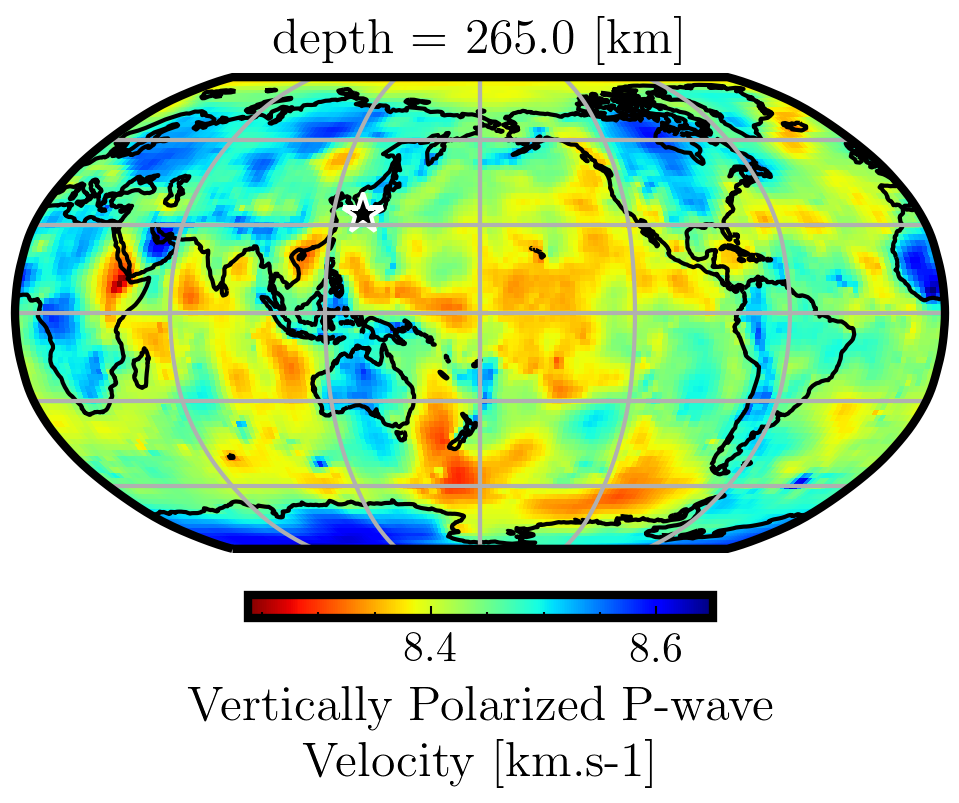

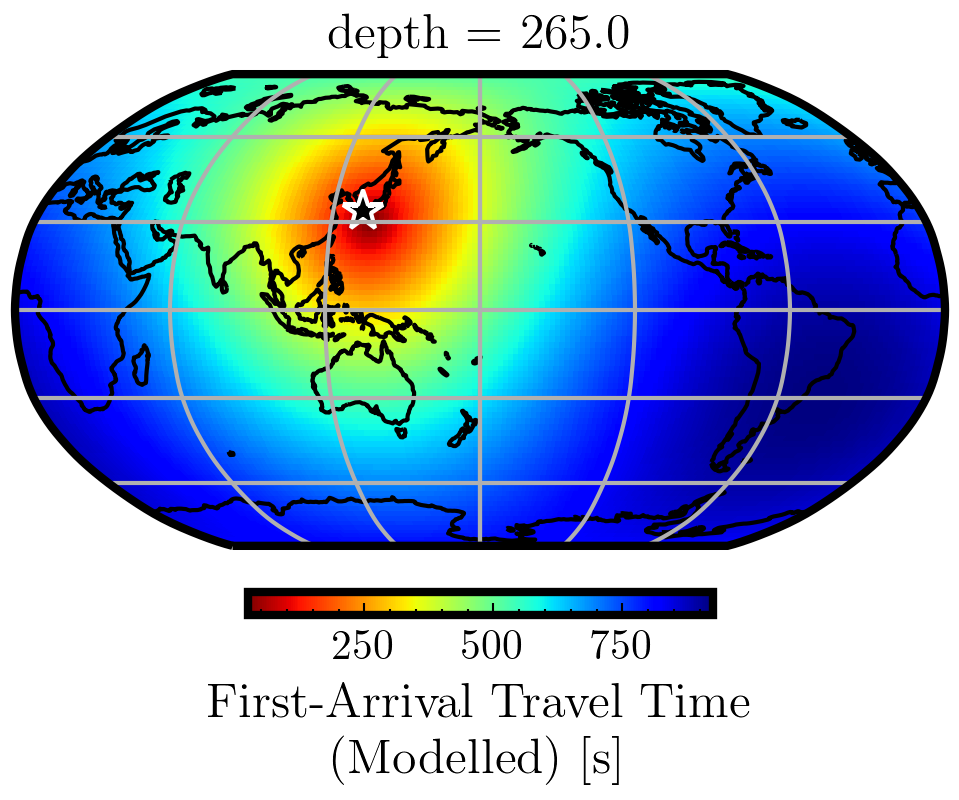

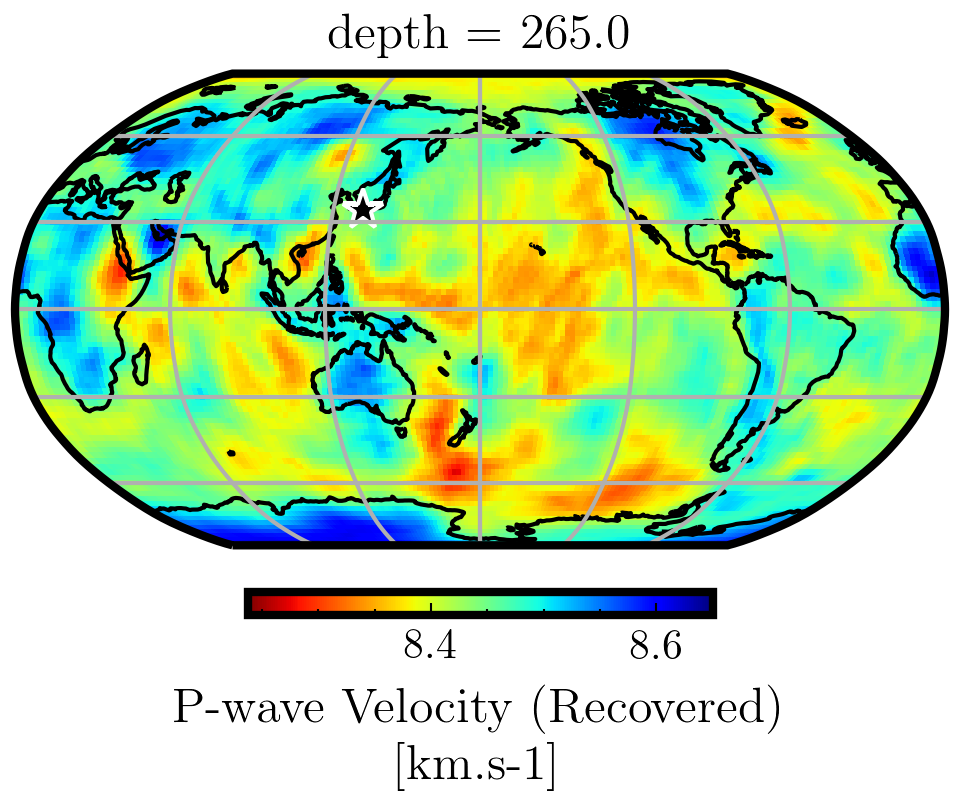

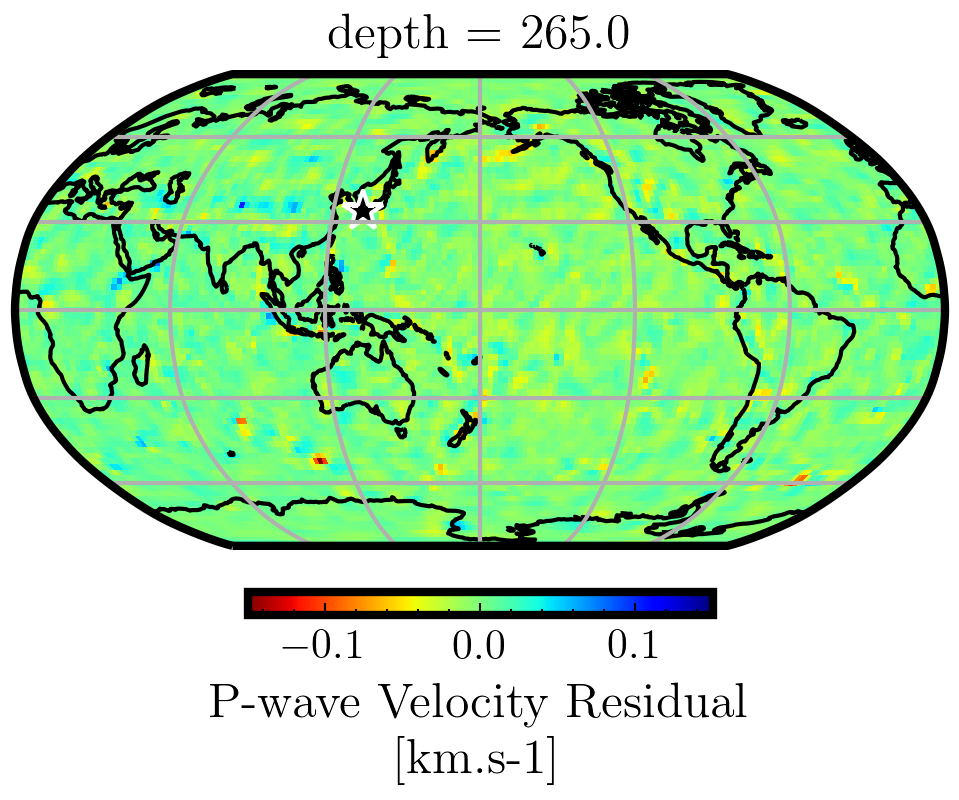

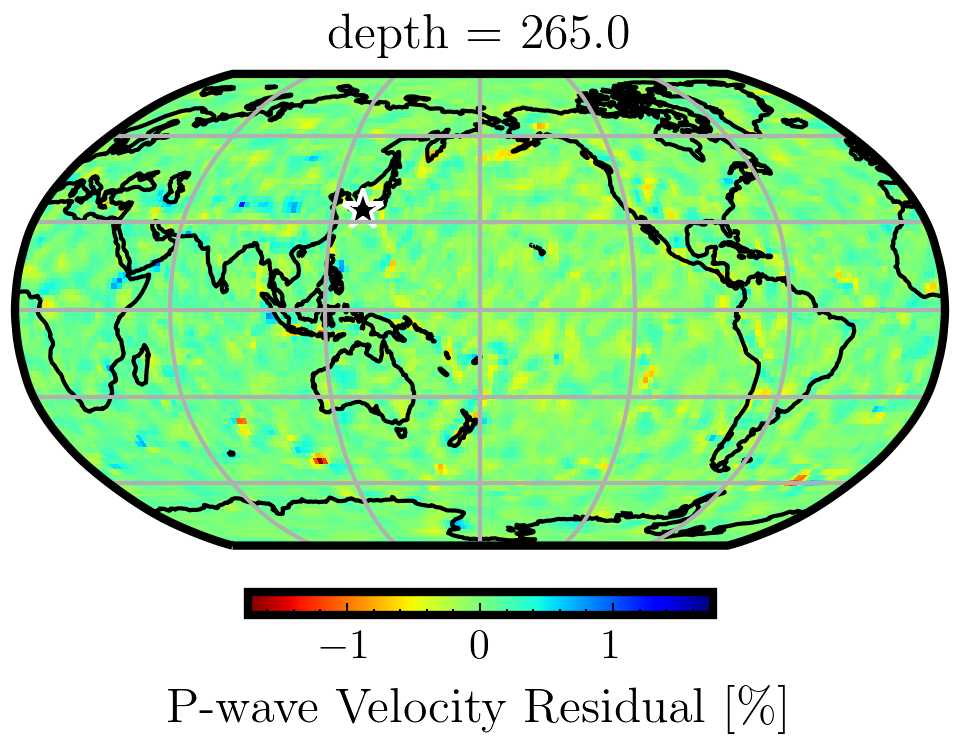

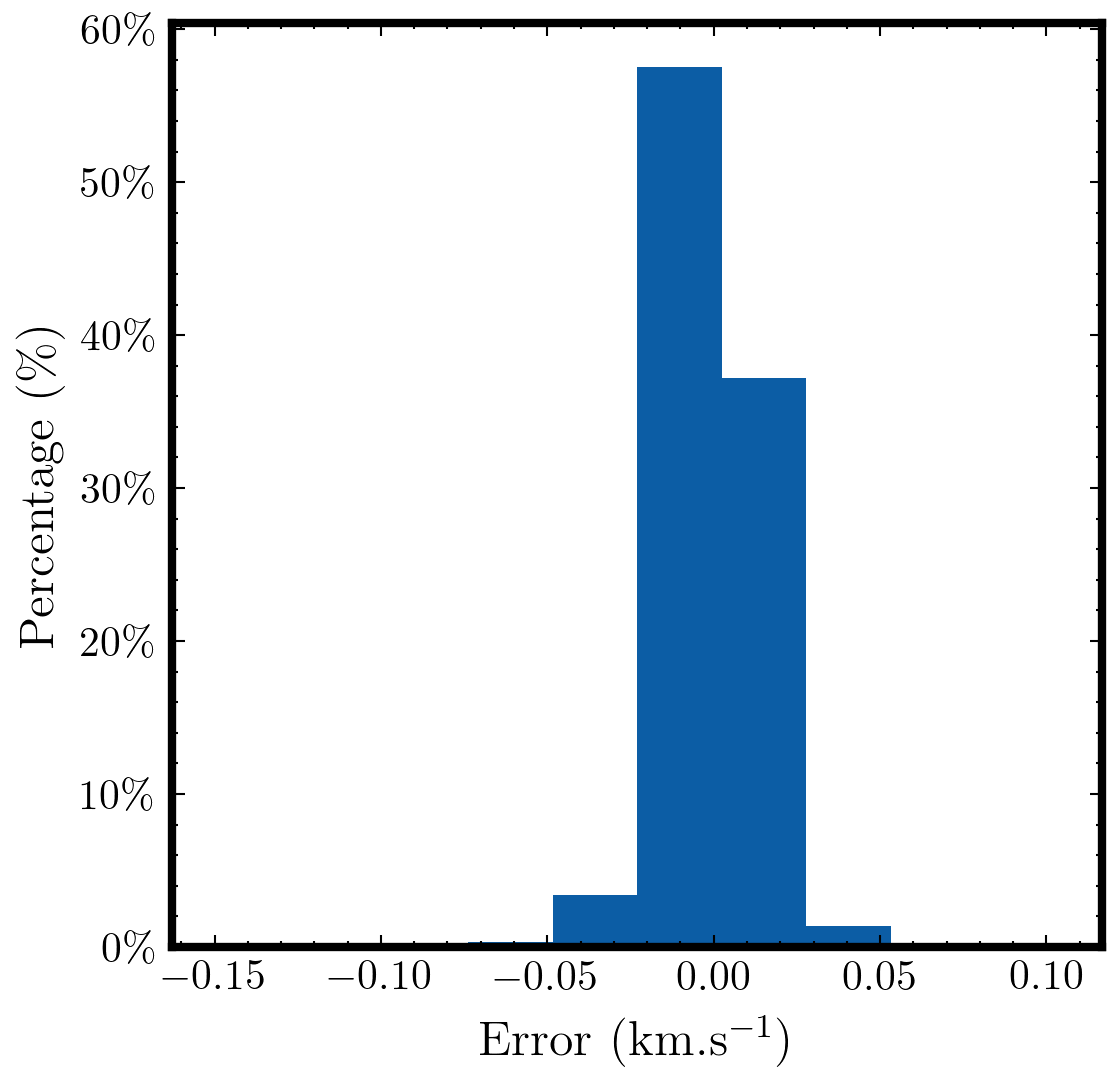

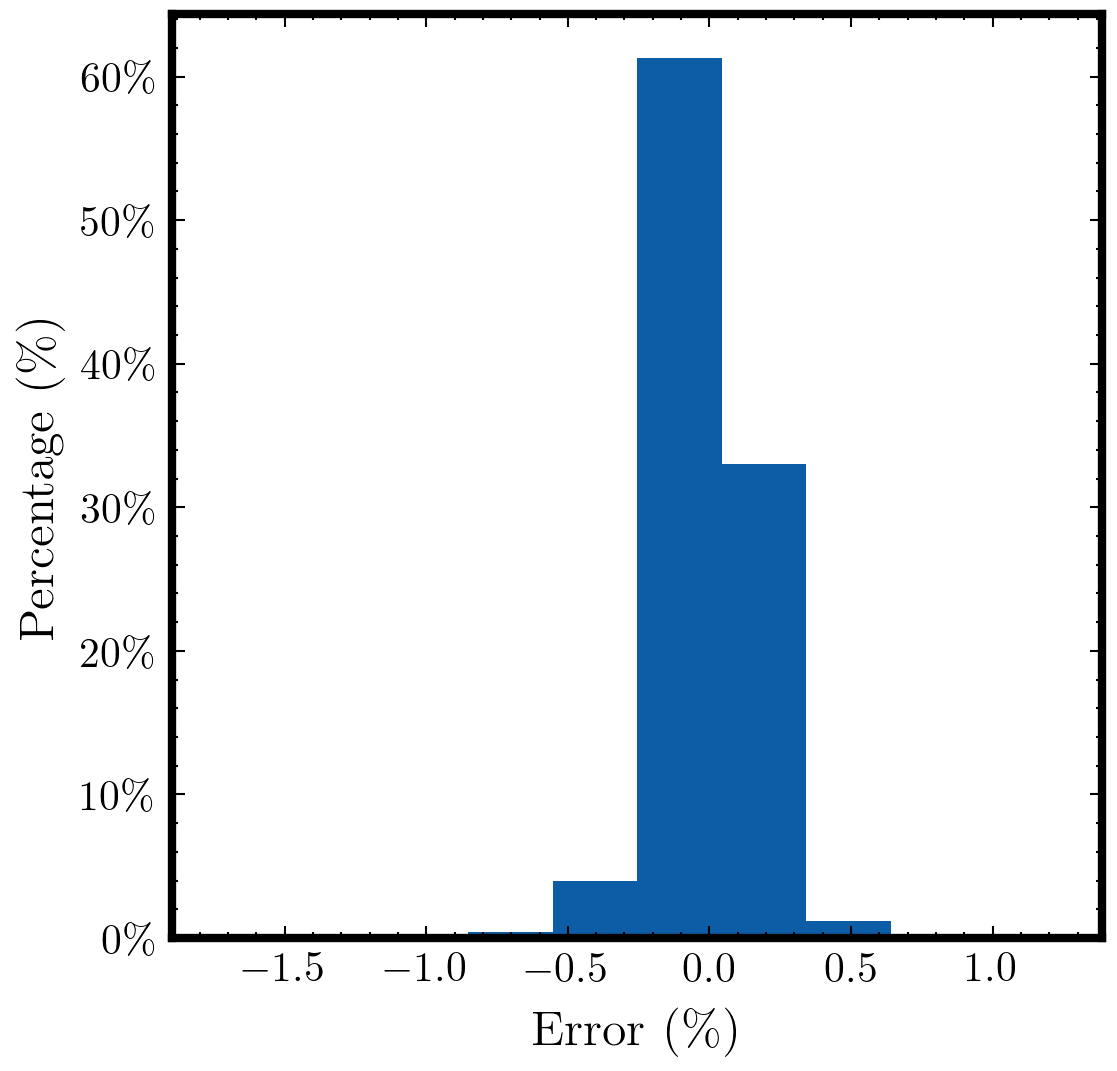

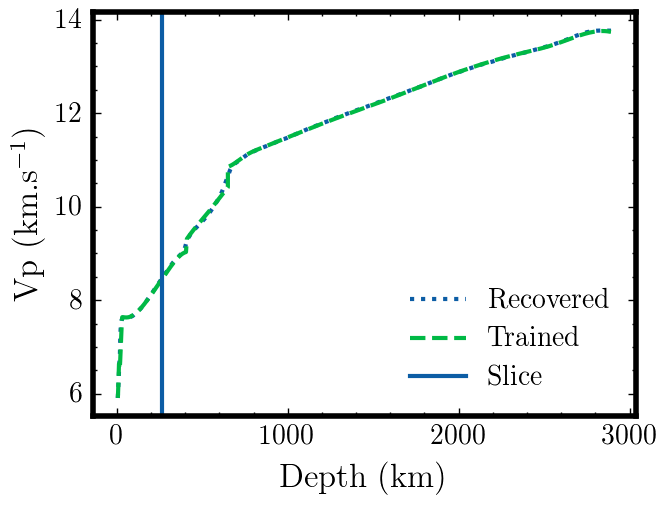

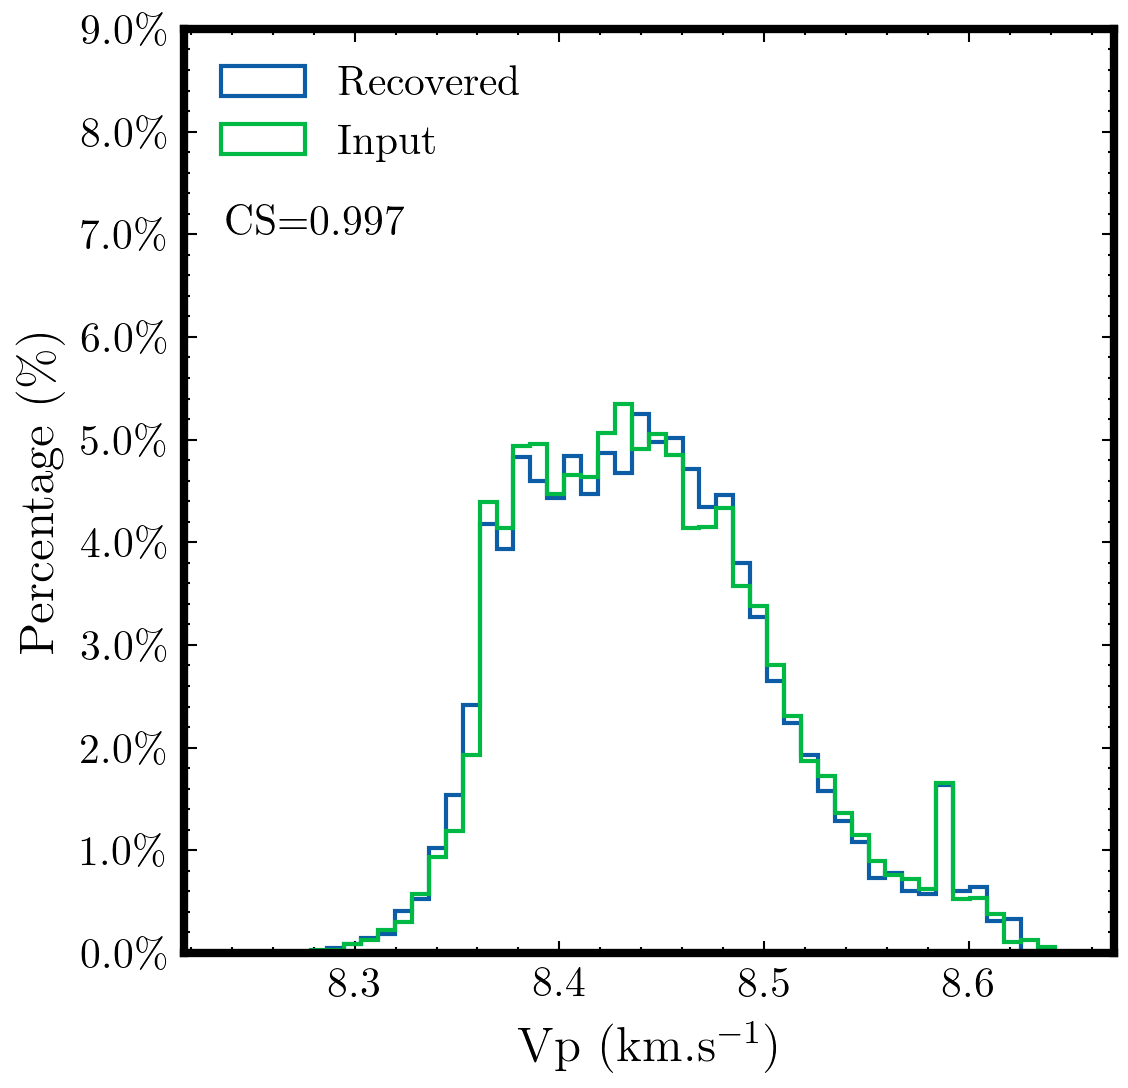

In [7]:
V_pred, T_pred = P['V_pred']*bac_vel, P['T_pred']/bac_vel

# Define depth slices
dep_plt = [
    depth.flat[np.abs(depth - id).argmin()] for id in [265] #np.arange(25,3000,225)
]

# construct xarray data
pred = xr.Dataset({
    'V_pred': xr.DataArray(
        data=V_pred,
        dims=["depth", "latitude", "longitude"],
        coords=dict(
            depth = (["depth"], depth),
            longitude=(["longitude"], longitude),
            latitude=(["latitude"], latitude),
        ),
        attrs=dict(
            long_name='P-wave Velocity (Recovered)',
            description="Recovered Vp.",
            display_name='Vp (km.s^-1)',
            units="km.s-1",
        )
    ),
    'V_res': xr.DataArray(
        data=(V_pred-data.vpv[dep_ini::dep_inc, lat_ini::lat_inc, lon_ini::lon_inc].values),
        dims=["depth", "latitude", "longitude"],
        coords=dict(
            depth = (["depth"], depth),
            longitude=(["longitude"], longitude),
            latitude=(["latitude"], latitude),
        ),
        attrs=dict(
            long_name='P-wave Velocity Residual',
            description="Error Vp.",
            display_name='Vp (km.s^-1)',
            units="km.s-1",
        )
    ),
    'V_rel': xr.DataArray(
        data=100*(V_pred-data.vpv[dep_ini::dep_inc, lat_ini::lat_inc, lon_ini::lon_inc].values)/data.vpv[dep_ini::dep_inc, lat_ini::lat_inc, lon_ini::lon_inc].values,
        dims=["depth", "latitude", "longitude"],
        coords=dict(
            depth = (["depth"], depth),
            longitude=(["longitude"], longitude),
            latitude=(["latitude"], latitude),
        ),
        attrs=dict(
            long_name='P-wave Velocity Residual',
            description="Relative Error Vp.",
            display_name='Vp/Vp (\%)',
            units="\%",
        )
    ),
    'T_pred': xr.DataArray(
        data=T_pred*ear_rad,
        dims=["depth", "latitude", "longitude"],
        coords=dict(
            depth = (["depth"], depth),
            longitude=(["longitude"], longitude),
            latitude=(["latitude"], latitude),
        ),
        attrs=dict(
            long_name='First-Arrival Travel Time (Modelled)',
            description="Recovered T.",
            display_name='T (s)',
            units="s",
        )
    )
})

for ip in dep_plt:

    fig = plt.figure(figsize=(4,4), dpi=300)
    ax = plt.axes(projection=ccrs.Robinson(180))
    ax.coastlines()
    ax.gridlines()
    data.vpv[dep_ini::dep_inc, lat_ini::lat_inc, lon_ini::lon_inc][depth==ip].plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cbar_kwargs={'shrink': 0.5, 'extend':'neither', 'orientation':'horizontal','pad':0.05}, 
        cmap='jet_r',
        vmin=data.vpv[dep_ini::dep_inc, lat_ini::lat_inc, lon_ini::lon_inc][depth==ip].values.min(),
        vmax=data.vpv[dep_ini::dep_inc, lat_ini::lat_inc, lon_ini::lon_inc][depth==ip].values.max()
    )

    plt.plot(lon_sou, lat_sou,color='black', markersize=10, marker='*',transform=ccrs.PlateCarree(), mec='white')
    plt.savefig(figures_path + 'V_ini_map_'+str(ip)+'_noTit.pdf', bbox_inches="tight")
    # plt.show()

    fig = plt.figure(figsize=(4,4), dpi=300)
    ax = plt.axes(projection=ccrs.Robinson(180))

    # print(pred.T_pred[depth==ip].values.min(), dep_sou)

    ax.coastlines()
    ax.gridlines()
    pred.T_pred[depth==ip].plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cbar_kwargs={'shrink': 0.5, 'extend':'neither', 'orientation':'horizontal','pad':0.05}, 
        cmap='jet_r',
        vmin=pred.T_pred[depth==ip].values.min(),
        vmax=pred.T_pred[depth==ip].values.max()
    )
    plt.plot(lon_sou, lat_sou,color='black', markersize=10, marker='*',transform=ccrs.PlateCarree(), mec='white')
    plt.savefig(figures_path + 'T_pred_map_'+str(ip)+'_noTit.pdf', bbox_inches="tight")
    # plt.show()

    fig = plt.figure(figsize=(4,4), dpi=300)
    ax = plt.axes(projection=ccrs.Robinson(180))

    ax.coastlines()
    ax.gridlines()
    pred.V_pred[depth==ip].plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cbar_kwargs={'shrink': 0.5, 'extend':'neither', 'orientation':'horizontal','pad':0.05}, 
        cmap='jet_r',
        vmin=data.vpv[dep_ini::dep_inc, lat_ini::lat_inc, lon_ini::lon_inc][depth==ip].values.min(),
        vmax=data.vpv[dep_ini::dep_inc, lat_ini::lat_inc, lon_ini::lon_inc][depth==ip].values.max()
    )
    plt.plot(lon_sou, lat_sou,color='black', markersize=10, marker='*',transform=ccrs.PlateCarree(), mec='white')
    plt.savefig(figures_path + 'V_pred_map_'+str(ip)+'_noTit.pdf', bbox_inches="tight")
    # plt.show()
    
    fig = plt.figure(figsize=(4,4), dpi=300)
    ax = plt.axes(projection=ccrs.Robinson(180))

    ax.coastlines()
    ax.gridlines()
    pred.V_res[depth==ip].plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cbar_kwargs={'shrink': 0.5, 'extend':'neither', 'orientation':'horizontal','pad':0.05}, 
        cmap='jet_r'
    )
    plt.plot(lon_sou, lat_sou,color='black', markersize=10, marker='*',transform=ccrs.PlateCarree(), mec='white')
    plt.savefig(figures_path + 'V_res_map_'+str(ip)+'_noTit.pdf', bbox_inches="tight")
    # plt.show()

    fig = plt.figure(figsize=(4,4), dpi=300)
    ax = plt.axes(projection=ccrs.Robinson(180))

    ax.coastlines()
    ax.gridlines()
    pred.V_rel[depth==ip].plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cbar_kwargs={'shrink': 0.5, 'extend':'neither', 'orientation':'horizontal','pad':0.05}, 
        cmap='jet_r'
    )
    plt.plot(lon_sou, lat_sou,color='black', markersize=10, marker='*',transform=ccrs.PlateCarree(), mec='white')
    plt.savefig(figures_path + 'V_rel_map_'+str(ip)+'_noTit.pdf', bbox_inches="tight")
    # plt.show()

    fig = plt.figure(figsize=(4,4), dpi=300)
    D = pred.V_res[depth==ip].values.reshape(-1,)
    plt.hist(D, weights=np.ones(len(D)) / len(D))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    # plt.title('Relative Error at Depth '+str(ip)+' (km)')
    plt.ylabel('Percentage (\%)')
    plt.xlabel(r'Error (km.s$^{-1}$)')
    plt.savefig(figures_path + 'V_hist_'+str(ip)+'_noTit.pdf', bbox_inches="tight")

    fig = plt.figure(figsize=(4,4), dpi=300)
    D = pred.V_rel[depth==ip].values.reshape(-1,)
    plt.hist(D, weights=np.ones(len(D)) / len(D))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    # plt.title('Relative Error at Depth '+str(ip)+' (km)')
    plt.ylabel('Percentage (\%)')
    plt.xlabel('Error (\%)')
    # plt.xlim(-1.1,1.1)
    plt.savefig(figures_path + 'V_hist_rel_'+str(ip)+'_noTit.pdf', bbox_inches="tight")

    plt.figure()
    plt.plot(depth, V_pred[:,latitude==lat_sou,longitude==lon_sou], ':', label='Recovered')
    plt.plot(depth, vpv[:,latitude==lat_sou,longitude==lon_sou], '--', label='Trained')
    plt.axvline(x=ip, label='Slice')
    # plt.title('1-D Profile Comparison')
    plt.xlabel('Depth (km)')
    plt.ylabel(r'Vp (km.s$^{-1}$)')
    plt.legend()
    plt.savefig(figures_path + 'V_comp_1d_'+str(ip)+'_noTit.pdf', bbox_inches="tight")

    fig = plt.figure(figsize=(4,4), dpi=300)
    P = pred.V_pred[depth==ip].values.reshape(-1,)
    D = data.vpv[dep_ini::dep_inc, lat_ini::lat_inc, lon_ini::lon_inc].values[depth==ip].reshape(-1,)
    n_P, bins_P, patches_P = plt.hist(
        P, 
        weights=np.ones(len(P)) / len(P), 
        bins=50, 
        histtype='step', 
        range=(D.min(), D.max()), 
        label='Recovered'
    )
    n_D, bins_D, patches_D = plt.hist(
        D, 
        weights=np.ones(len(P)) / len(P), 
        bins=50, 
        histtype='step', 
        range=(D.min(), D.max()), 
        label='Input'
    )
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    # # plt.title('Velocity Histogram')
    # plt.title('Velocity Histogram at Depth '+str(ip)+' (km)')
    plt.ylabel('Percentage (\%)')
    plt.xlabel(r'Vp (km.s$^{-1}$)')
    plt.legend(loc='upper left')
    plt.ylim(0,0.09)
    plt.text(
        np.min([D,P]),# +0.5*(np.max([D,P])-np.min([D,P])),
        0.07, 
        "CS="+str(round(1 - spatial.distance.cosine(n_D, n_P),3))
    )
    plt.savefig(figures_path + 'V_comp_hist_'+str(ip)+'_noTit.pdf', bbox_inches="tight")

## Histograms and 1-D Profiles

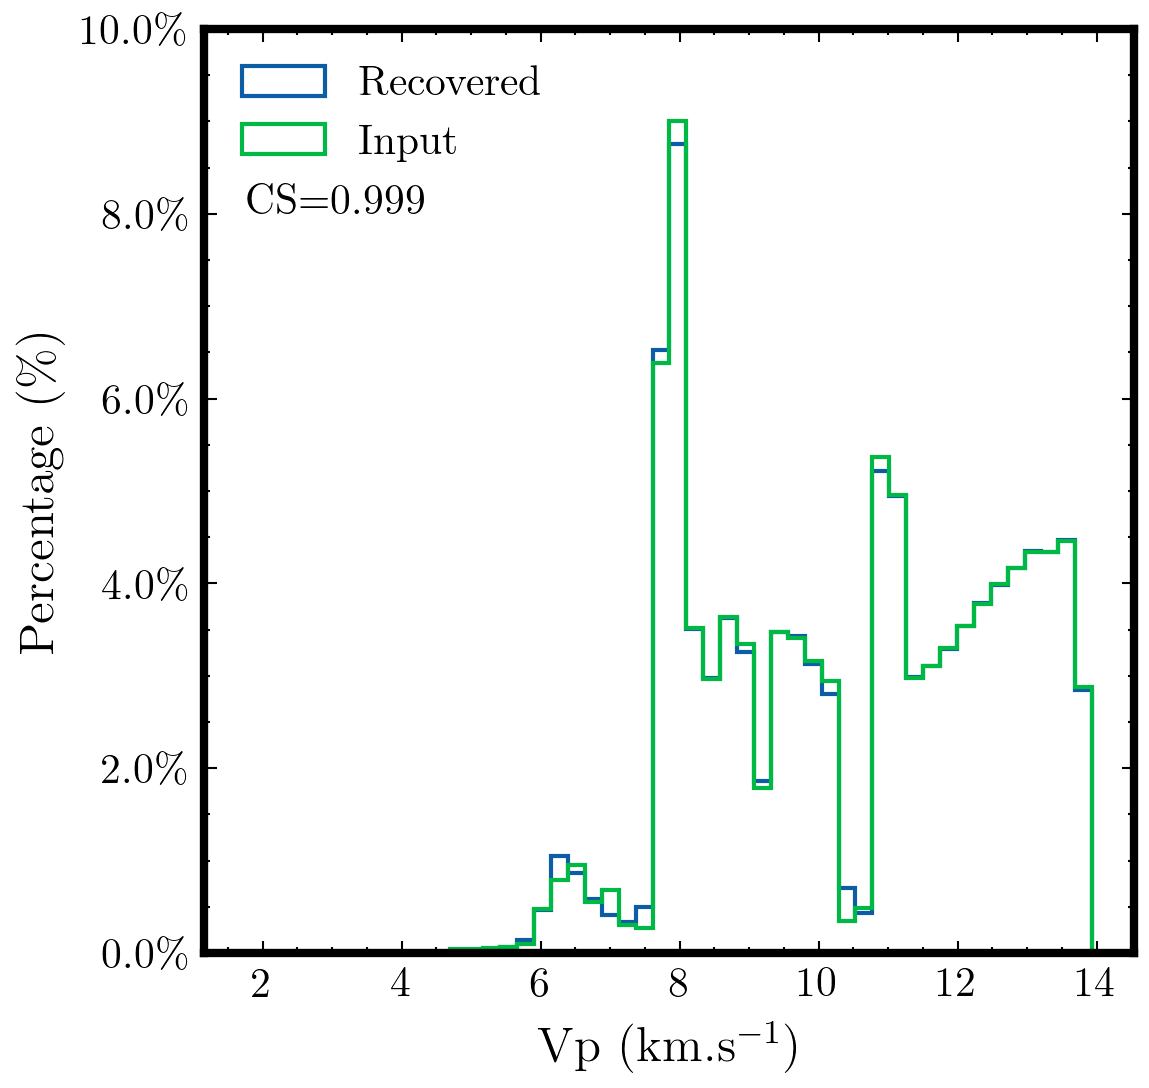

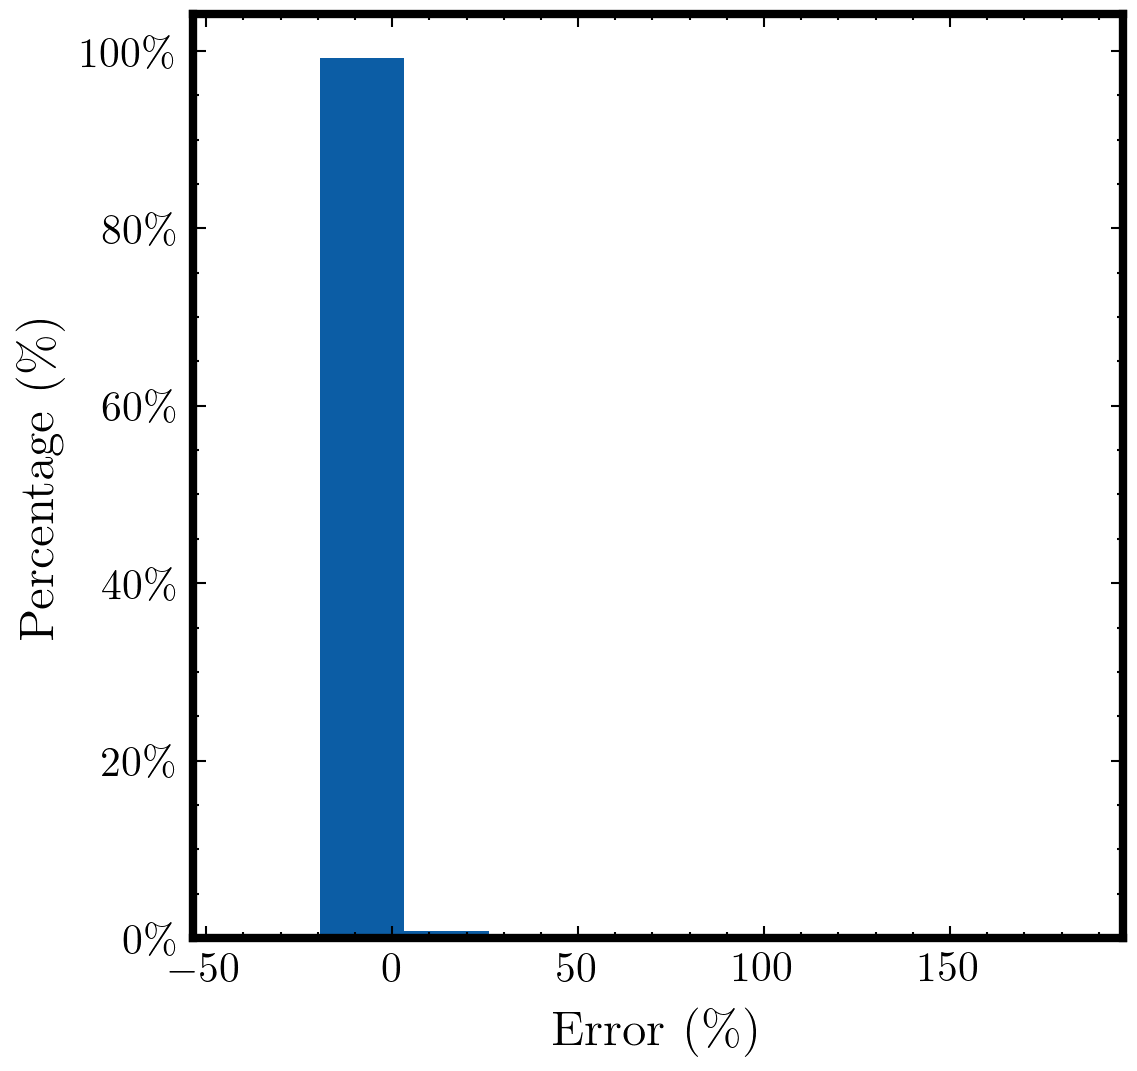

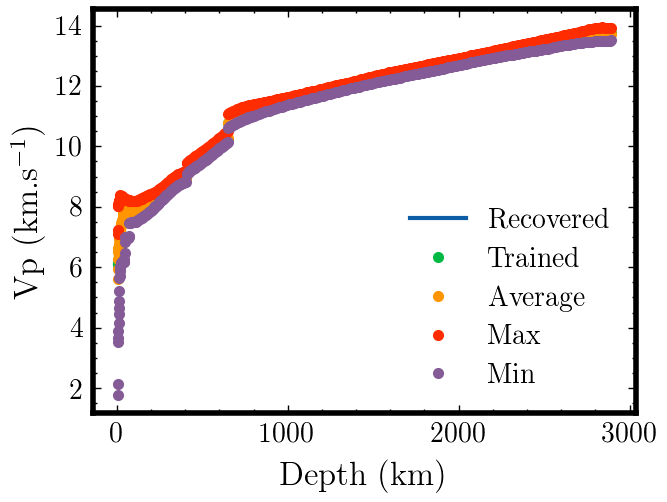

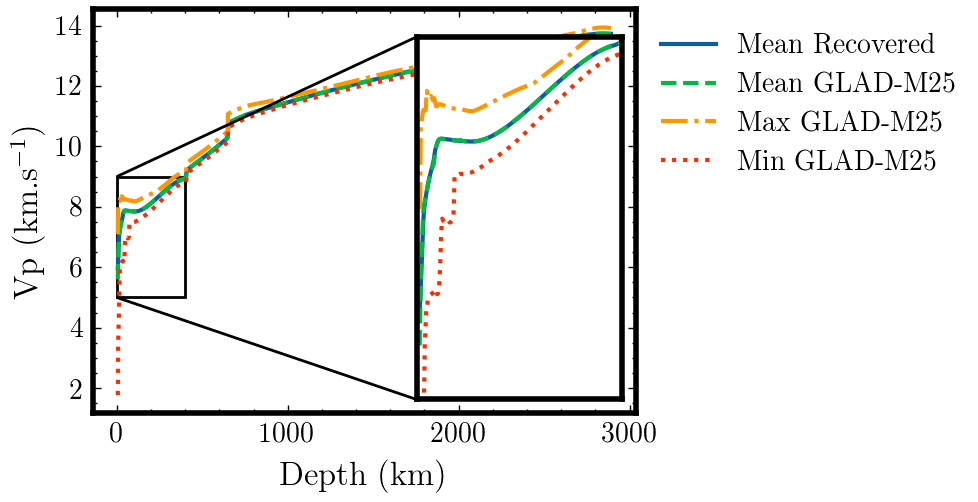

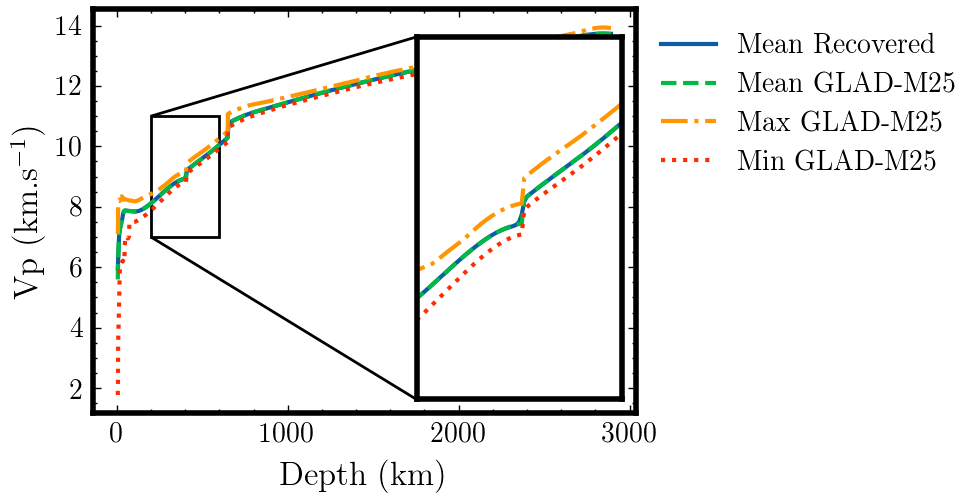

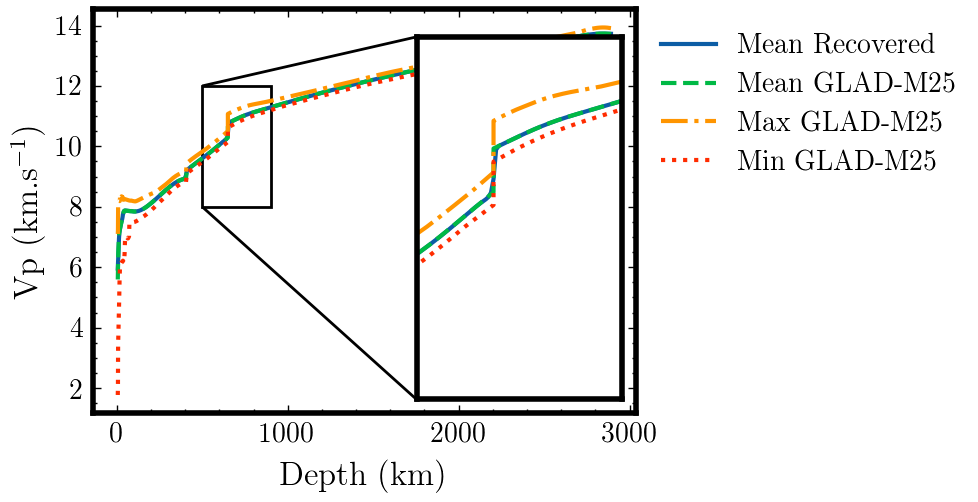

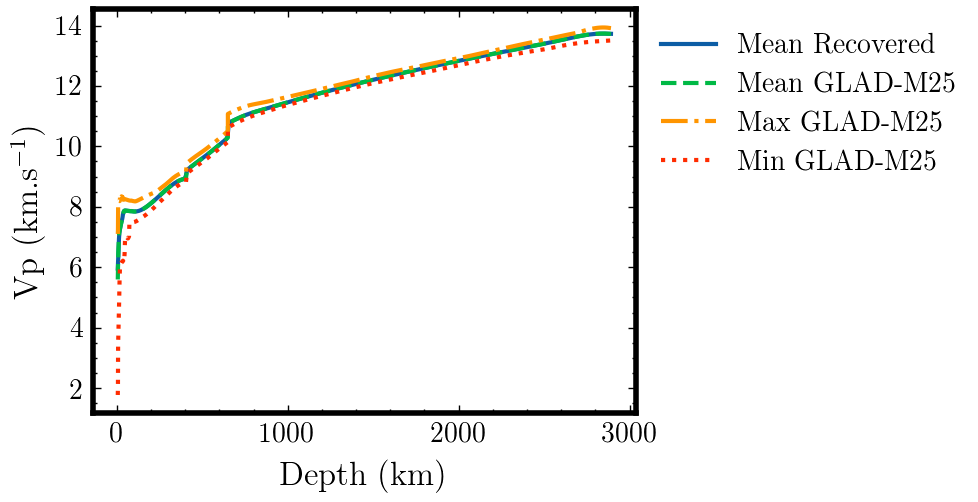

In [10]:
fig = plt.figure(figsize=(4,4), dpi=300)
P = pred.V_pred.values.reshape(-1,)
D = data.vpv[dep_ini::dep_inc, lat_ini::lat_inc, lon_ini::lon_inc].values.reshape(-1,)
n_P, bins_P, patches_P = plt.hist(
    P, 
    weights=np.ones(len(P)) / len(P), 
    bins=50, 
    histtype='step', 
    range=(D.min(), D.max()), 
    label='Recovered'
)
n_D, bins_D, patches_D = plt.hist(
    D, 
    weights=np.ones(len(P)) / len(P), 
    bins=50, 
    histtype='step', 
    range=(D.min(), D.max()), 
    label='Input'
)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.title('Velocity Histogram')
plt.ylabel('Percentage (\%)')
plt.xlabel(r'Vp (km.s$^{-1}$)')
plt.legend(loc='upper left')
plt.ylim(0,0.10)
plt.text(
    np.min([D,P]),# +0.5*(np.max([D,P])-np.min([D,P])),
    0.08, 
    "CS="+str(round(1 - spatial.distance.cosine(n_D, n_P),3))
)
plt.savefig(figures_path + 'V_comp_hist_all_noTit.pdf', bbox_inches="tight")

fig = plt.figure(figsize=(4,4), dpi=300)
D = pred.V_rel.values.reshape(-1,)
plt.hist(D, weights=np.ones(len(D)) / len(D))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.title('Relative Error')
plt.ylabel('Percentage (\%)')
plt.xlabel('Error (\%)')
plt.savefig(figures_path + 'V_hist_rel_noTit.pdf', bbox_inches="tight")

colnames=['depth', 'vp', 'vs', 'rho']
ek137 = pd.read_csv('../data/ek137.tvel', skiprows=2, header=None, delim_whitespace=1, names=colnames)
depth_ek = ek137.depth.values
vp_ek = ek137.vp.values

# 1D Validation
vp_min = [np.min(vpv[i,:,:]) for i in range(len(depth))]
vp_max = [np.max(vpv[i,:,:]) for i in range(len(depth))]
vp_mean = [np.mean(vpv[i,:,:]) for i in range(len(depth))]
plt.figure()
plt.plot(depth, V_pred[:,0,0], label='Recovered')
plt.plot(depth, vpv[:,0,0], '.', label='Trained')
plt.plot(depth, vp_mean, '.', label='Average')
plt.plot(depth, vp_max, '.', label='Max')
plt.plot(depth, vp_min, '.', label='Min')
# plt.plot(depth_ek[depth_ek<=np.max(depth)], vp_ek[depth_ek<=np.max(depth)], label=r'1-D $\emph{ek137}$')
# plt.title('1-D Profile Comparison')
plt.xlabel('Depth (km)')
plt.ylabel(r'Vp (km.s$^{-1}$)')
plt.legend()
plt.savefig(figures_path + 'V_comp_1d_noTit.pdf', bbox_inches="tight")

fig, ax = plt.subplots(1)
ax.plot(depth, [np.mean(V_pred[i,:,:]) for i in range(len(depth))], label='Mean Recovered')
ax.plot(depth, vp_mean, '--', label='Mean GLAD-M25')
ax.plot(depth, vp_max, '-.', label='Max GLAD-M25')
ax.plot(depth, vp_min, ':', label='Min GLAD-M25')
# ax.plot(depth_ek[depth_ek<=np.max(depth)], vp_ek[depth_ek<=np.max(depth)], 'g', label=r'$\emph{ek137}$')
# ax.set_title('1-D Profile Comparison')
ax.set_xlabel('Depth (km)')
ax.set_ylabel(r'Vp (km.s$^{-1}$)')
ax.legend(bbox_to_anchor=(1., 1.))

axins = zoomed_inset_axes(ax,3,loc='lower right')
axins.plot(depth, [np.mean(V_pred[i,:,:]) for i in range(len(depth))], label='Mean Recovered')
axins.plot(depth, vp_mean, '--', label='Mean GLAD-M25')
axins.plot(depth, vp_max, '-.', label='Max GLAD-M25')
axins.plot(depth, vp_min, ':', label='Min GLAD-M25')
# axins.plot(depth_ek[depth_ek<=np.max(depth)], vp_ek[depth_ek<=np.max(depth)], 'g', label=r'$\emph{ek137}$')
x1,x2,y1,y2 = 0,400,5,9
axins.set_xlim(x1,x2)
axins.set_ylim(y1,y2)
axins.set_xticks([])
axins.set_yticks([])

mark_inset(ax,axins,loc1=2,loc2=3)

plt.savefig(figures_path + 'V_comp_1d_box1_noTit.pdf', bbox_inches="tight")

fig, ax = plt.subplots(1)
ax.plot(depth, [np.mean(V_pred[i,:,:]) for i in range(len(depth))], label='Mean Recovered')
ax.plot(depth, vp_mean, '--', label='Mean GLAD-M25')
ax.plot(depth, vp_max, '-.', label='Max GLAD-M25')
ax.plot(depth, vp_min, ':', label='Min GLAD-M25')
# ax.plot(depth_ek[depth_ek<=np.max(depth)], vp_ek[depth_ek<=np.max(depth)], 'g', label=r'$\emph{ek137}$')
# ax.set_title('1-D Profile Comparison')
ax.set_xlabel('Depth (km)')
ax.set_ylabel(r'Vp (km.s$^{-1}$)')
ax.legend(bbox_to_anchor=(1., 1.))

axins = zoomed_inset_axes(ax,3,loc='lower right')
axins.plot(depth, [np.mean(V_pred[i,:,:]) for i in range(len(depth))], label='Mean Recovered')
axins.plot(depth, vp_mean, '--', label='Mean GLAD-M25')
axins.plot(depth, vp_max, '-.', label='Max GLAD-M25')
axins.plot(depth, vp_min, ':', label='Min GLAD-M25')
# axins.plot(depth_ek[depth_ek<=np.max(depth)], vp_ek[depth_ek<=np.max(depth)], 'g', label=r'$\emph{ek137}$')
x1,x2,y1,y2 = 200,600,7,11
axins.set_xlim(x1,x2)
axins.set_ylim(y1,y2)
axins.set_xticks([])
axins.set_yticks([])

mark_inset(ax,axins,loc1=2,loc2=3)

plt.savefig(figures_path + 'V_comp_1d_box2_noTit.pdf', bbox_inches="tight")

fig, ax = plt.subplots(1)
ax.plot(depth, [np.mean(V_pred[i,:,:]) for i in range(len(depth))], label='Mean Recovered')
ax.plot(depth, vp_mean, '--', label='Mean GLAD-M25')
ax.plot(depth, vp_max, '-.', label='Max GLAD-M25')
ax.plot(depth, vp_min, ':', label='Min GLAD-M25')
# ax.plot(depth_ek[depth_ek<=np.max(depth)], vp_ek[depth_ek<=np.max(depth)], 'g', label=r'$\emph{ek137}$')
# ax.set_title('1-D Profile Comparison')
ax.set_xlabel('Depth (km)')
ax.set_ylabel(r'Vp (km.s$^{-1}$)')
ax.legend(bbox_to_anchor=(1., 1.))

axins = zoomed_inset_axes(ax,3,loc='lower right')
axins.plot(depth, [np.mean(V_pred[i,:,:]) for i in range(len(depth))], label='Mean Recovered')
axins.plot(depth, vp_mean, '--', label='Mean GLAD-M25')
axins.plot(depth, vp_max, '-.', label='Max GLAD-M25')
axins.plot(depth, vp_min, ':', label='Min GLAD-M25')
# axins.plot(depth_ek[depth_ek<=np.max(depth)], vp_ek[depth_ek<=np.max(depth)], 'g', label=r'$\emph{ek137}$')
x1,x2,y1,y2 = 500,900,8,12
axins.set_xlim(x1,x2)
axins.set_ylim(y1,y2)
axins.set_xticks([])
axins.set_yticks([])

mark_inset(ax,axins,loc1=2,loc2=3)

plt.savefig(figures_path + 'V_comp_1d_box3_noTit.pdf', bbox_inches="tight")

fig, ax = plt.subplots(1)
ax.plot(depth, [np.mean(V_pred[i,:,:]) for i in range(len(depth))], label='Mean Recovered')
ax.plot(depth, vp_mean, '--', label='Mean GLAD-M25')
ax.plot(depth, vp_max, '-.', label='Max GLAD-M25')
ax.plot(depth, vp_min, ':', label='Min GLAD-M25')
# ax.plot(depth_ek[depth_ek<=np.max(depth)], vp_ek[depth_ek<=np.max(depth)], 'g', label=r'$\emph{ek137}$')
# ax.set_title('1-D Profile Comparison')
ax.set_xlabel('Depth (km)')
ax.set_ylabel(r'Vp (km.s$^{-1}$)')
ax.legend(bbox_to_anchor=(1., 1.))

plt.savefig(figures_path + 'V_comp_1d_plain_noTit.pdf', bbox_inches="tight")

## Vertical Slices

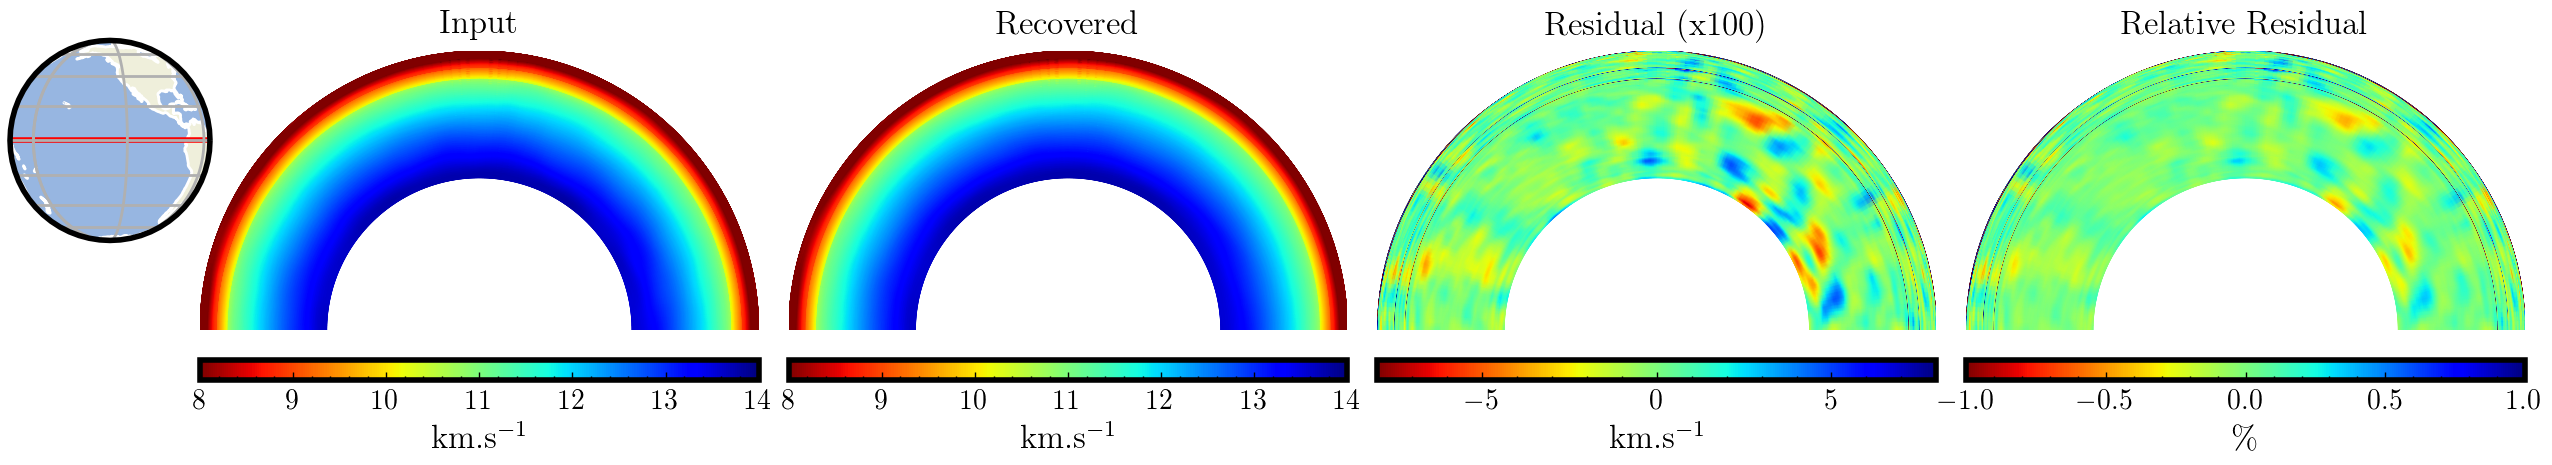

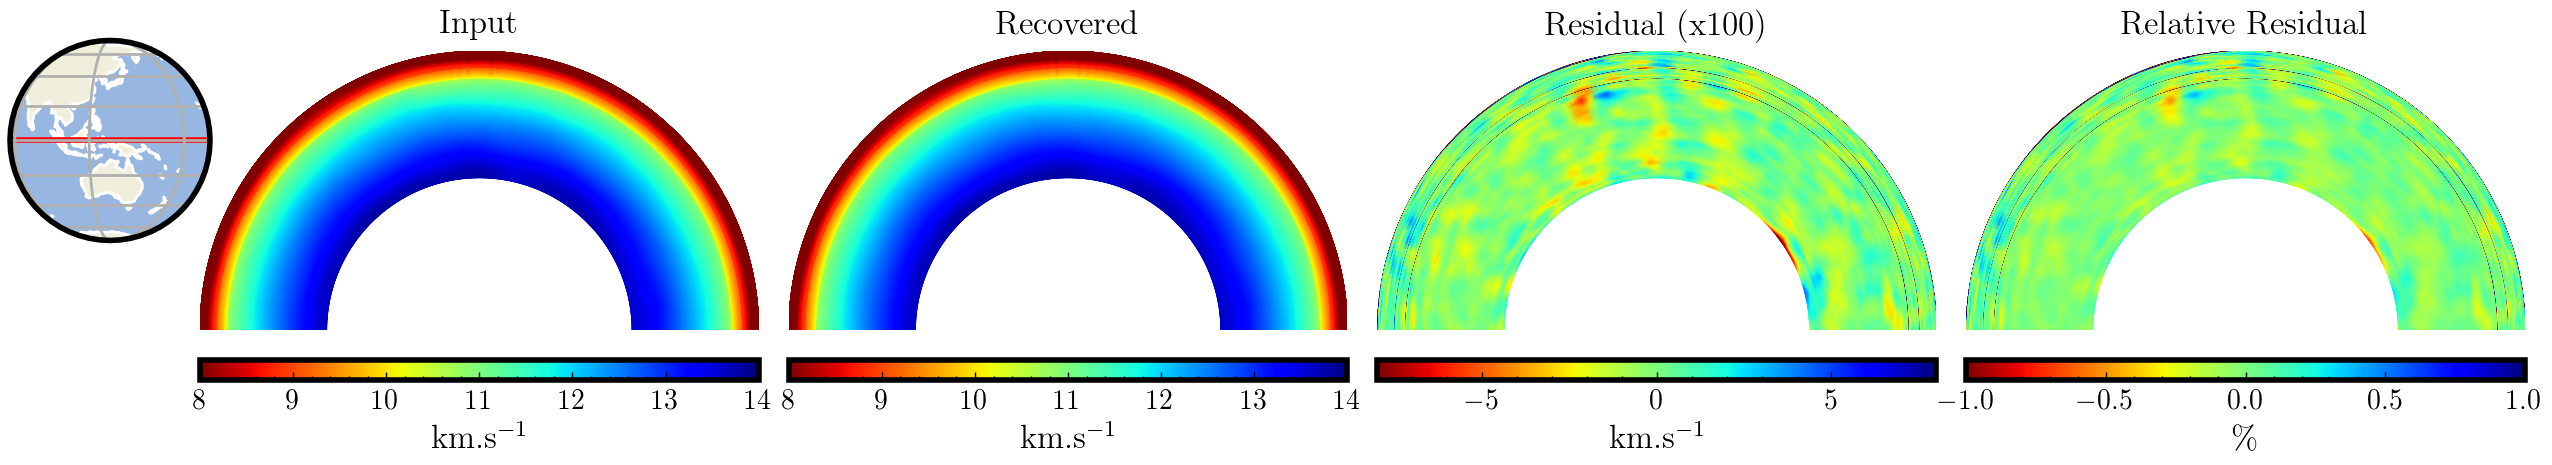

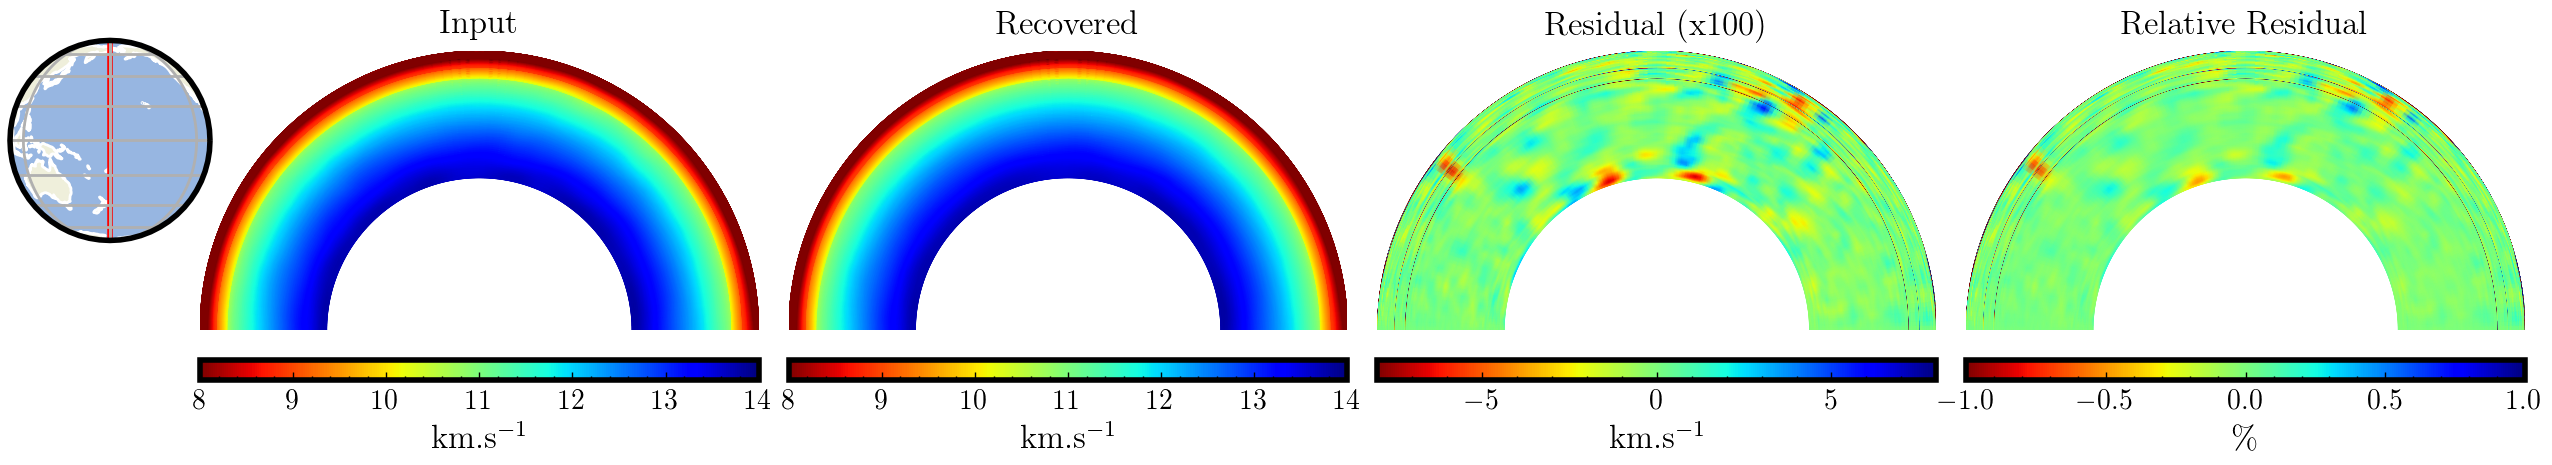

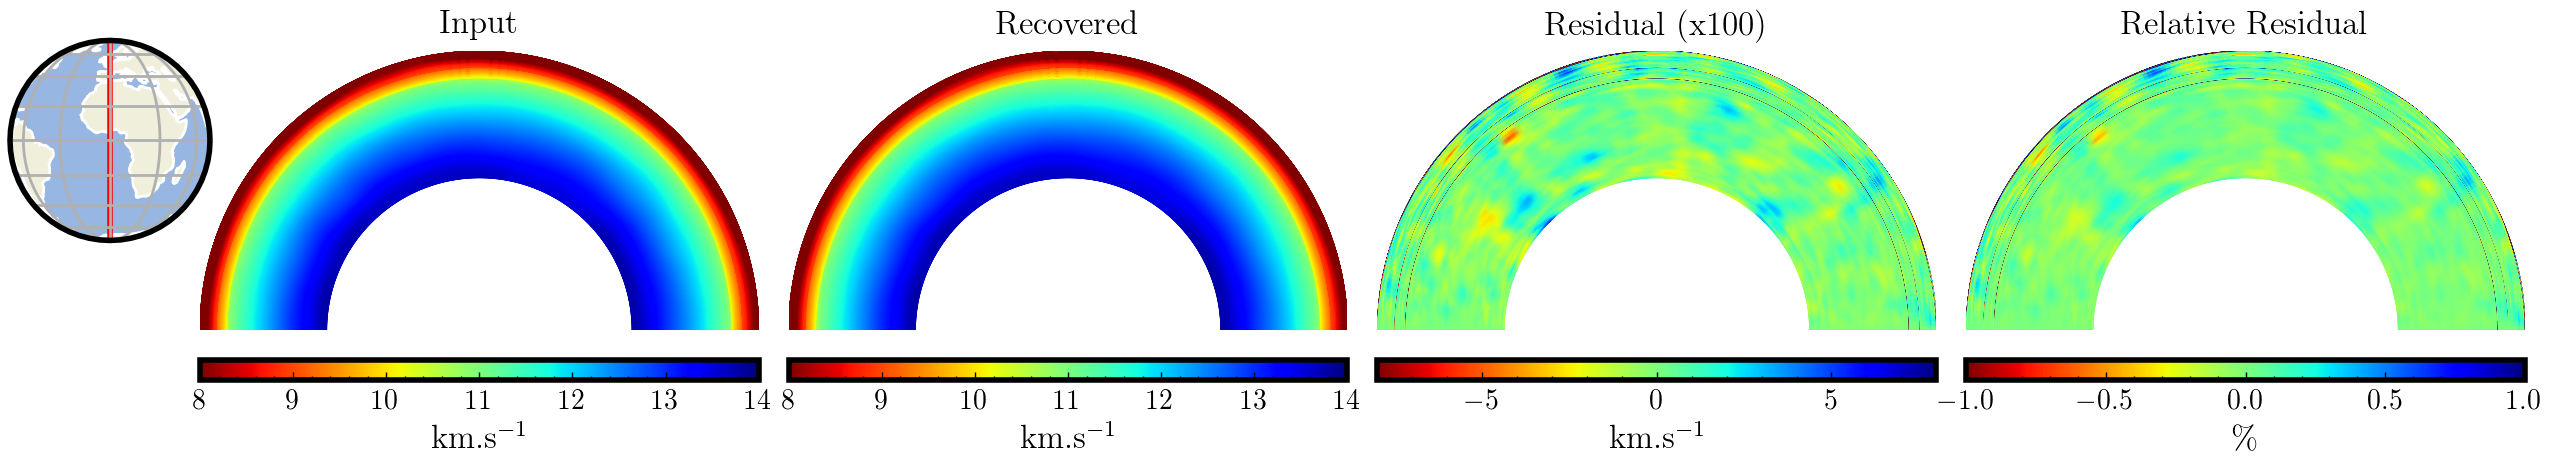

In [8]:
# Set up figure and image grid
fig = plt.figure(figsize=(15, 5))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,4),
                 axes_pad=0.15,
#                  share_all=True,
                 cbar_location="bottom",
                 cbar_mode="each",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )
i = 0

D = vpv[:,latitude.shape[0]//2,:].squeeze()
P = V_pred[:,latitude.shape[0]//2,:].squeeze()

for ax in grid:
    ax.axis('off')
    if i == 0:
        ax.set_title('Input')
        im1 = ax.pcolormesh(
            xx[:,latitude.shape[0]//2,:].squeeze(),
            yy[:,latitude.shape[0]//2,:].squeeze(),
            D,
            cmap=plt.get_cmap("jet_r"),
            shading="gouraud",
            vmin=8,
            vmax=14
        )
        # Colorbar
        cbar = ax.cax.colorbar(im1)
        cbar.set_label(r'km.s$^{-1}$')
        ax.cax.toggle_label(True)
    elif i == 1:
        ax.set_title('Recovered')
        im2 = ax.pcolormesh(
            xx[:,latitude.shape[0]//2,:].squeeze(),
            yy[:,latitude.shape[0]//2,:].squeeze(),
            P,
            cmap=plt.get_cmap("jet_r"),
            shading="gouraud",
            vmin=8,
            vmax=14
        )
        cbar = ax.cax.colorbar(im2)
        cbar.set_label(r'km.s$^{-1}$')
        ax.cax.toggle_label(True)
    elif i == 2:
        ax.set_title('Residual (x100)')
        im3 = ax.pcolormesh(
            xx[:,latitude.shape[0]//2,:].squeeze(),
            yy[:,latitude.shape[0]//2,:].squeeze(),
            100*(P-D),
            cmap=plt.get_cmap("jet_r"),
            shading="gouraud",
            vmin=-8,
            vmax=8
        )
        # Colorbar
        cbar = ax.cax.colorbar(im3)
        cbar.set_label(r'km.s$^{-1}$')
        ax.cax.toggle_label(True)
    elif i == 3:
        ax.set_title('Relative Residual')
        im3 = ax.pcolormesh(
            xx[:,latitude.shape[0]//2,:].squeeze(),
            yy[:,latitude.shape[0]//2,:].squeeze(),
            100*(P-D)/D,
            cmap=plt.get_cmap("jet_r"),
            shading="gouraud",
            vmin=-1,
            vmax=1
        )
        # Colorbar
        cbar = ax.cax.colorbar(im3)
        cbar.set_label('\%')
        ax.cax.toggle_label(True)

    ax.set_ylim(0,-ear_rad/1e3)
    i += 1
    
ax0 = fig.add_axes([0.005,0.47,0.18,0.2],projection=ccrs.Orthographic(longitude[25], 0))
ax0.add_feature(cfeature.OCEAN, zorder=0)
ax0.add_feature(cfeature.LAND, zorder=0, edgecolor='white')
ax0.set_global()
ax0.gridlines()
ax0.plot(np.linspace(-180,180,100), np.ones(100)*latitude[latitude.shape[0]//2], 'r',transform=ccrs.PlateCarree(), linewidth=2)
plt.savefig(figures_path + 'vel_DS_lat1_noTit.pdf', bbox_inches="tight")

# Set up figure and image grid
fig = plt.figure(figsize=(15, 5))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,4),
                 axes_pad=0.15,
#                  share_all=True,
                 cbar_location="bottom",
                 cbar_mode="each",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )
i = 0

D = vpv[:,latitude.shape[0]//2,:].squeeze()
P = V_pred[:,latitude.shape[0]//2,:].squeeze()

for ax in grid:
    ax.axis('off')
    if i == 0:
        ax.set_title('Input')
        im1 = ax.pcolormesh(
            xx[:,latitude.shape[0]//2,:].squeeze(),
            yy[:,latitude.shape[0]//2,:].squeeze(),
            D,
            cmap=plt.get_cmap("jet_r"),
            shading="gouraud",
            vmin=8,
            vmax=14
        )
        # Colorbar
        cbar = ax.cax.colorbar(im1)
        cbar.set_label(r'km.s$^{-1}$')
        ax.cax.toggle_label(True)
    elif i == 1:
        ax.set_title('Recovered')
        im2 = ax.pcolormesh(
            xx[:,latitude.shape[0]//2,:].squeeze(),
            yy[:,latitude.shape[0]//2,:].squeeze(),
            P,
            cmap=plt.get_cmap("jet_r"),
            shading="gouraud",
            vmin=8,
            vmax=14
        )
        # Colorbar
        cbar = ax.cax.colorbar(im2)
        cbar.set_label(r'km.s$^{-1}$')
        ax.cax.toggle_label(True)
    elif i == 2:
        ax.set_title('Residual (x100)')
        im3 = ax.pcolormesh(
            xx[:,latitude.shape[0]//2,:].squeeze(),
            yy[:,latitude.shape[0]//2,:].squeeze(),
            100*(P-D),
            cmap=plt.get_cmap("jet_r"),
            shading="gouraud",
            vmin=-8,
            vmax=8
        )
        # Colorbar
        cbar = ax.cax.colorbar(im3)
        cbar.set_label(r'km.s$^{-1}$')
        ax.cax.toggle_label(True)
    elif i == 3:
        ax.set_title('Relative Residual')
        im3 = ax.pcolormesh(
            xx[:,latitude.shape[0]//2,:].squeeze(),
            yy[:,latitude.shape[0]//2,:].squeeze(),
            100*(P-D)/D,
            cmap=plt.get_cmap("jet_r"),
            shading="gouraud",
            vmin=-1,
            vmax=1
        )
        # Colorbar
        cbar = ax.cax.colorbar(im3)
        cbar.set_label('\%')
        ax.cax.toggle_label(True)
        
    ax.set_ylim(0,ear_rad/1e3)
    i += 1
    

ax0 = fig.add_axes([0.005,0.47,0.18,0.2],projection=ccrs.Orthographic(longitude[-25], 0))
ax0.add_feature(cfeature.OCEAN, zorder=0)
ax0.add_feature(cfeature.LAND, zorder=0, edgecolor='white')
ax0.set_global()
ax0.gridlines()
ax0.plot(np.linspace(-180,180,100), np.ones(100)*latitude[latitude.shape[0]//2], 'r',transform=ccrs.PlateCarree(), linewidth=2)
plt.savefig(figures_path + 'vel_DS_lat2_noTit.pdf', bbox_inches="tight")

xx = (ear_rad - DEP) * np.sin(np.radians(LAT+90)) * np.cos(np.radians(180+LON))/(1e3)
yy = (ear_rad - DEP) * np.sin(np.radians(LAT+90)) * np.sin(np.radians(180+LON))/(1e3)
zz = (ear_rad - DEP) * np.cos(np.radians(LAT+90)) / (1e3)

# Set up figure and image grid
fig = plt.figure(figsize=(15, 5))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,4),
                 axes_pad=0.15,
#                  share_all=True,
                 cbar_location="bottom",
                 cbar_mode="each",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )
i = 0

D = vpv[:,:,0].squeeze()
P = V_pred[:,:,0].squeeze()

for ax in grid:
    ax.axis('off')
    if i == 0:
        ax.set_title('Input')
        im1 = ax.pcolormesh(
            zz[:,:,0].squeeze(),
            xx[:,:,0].squeeze(),
            D,
            cmap=plt.get_cmap("jet_r"),
            shading="gouraud",
            vmin=8,
            vmax=14
        )
        # Colorbar
        cbar = ax.cax.colorbar(im1)
        cbar.set_label(r'km.s$^{-1}$')
        ax.cax.toggle_label(True)
    elif i == 1:
        ax.set_title('Recovered')
        im2 = ax.pcolormesh(
            zz[:,:,0].squeeze(),
            xx[:,:,0].squeeze(),
            P,
            cmap=plt.get_cmap("jet_r"),
            shading="gouraud",
            vmin=8,
            vmax=14
        )
        # Colorbar
        cbar = ax.cax.colorbar(im2)
        cbar.set_label(r'km.s$^{-1}$')
        ax.cax.toggle_label(True)
    elif i == 2:
        ax.set_title('Residual (x100)')
        im3 = ax.pcolormesh(
            zz[:,:,0].squeeze(),
            xx[:,:,0].squeeze(),
            100*(P-D),
            cmap=plt.get_cmap("jet_r"),
            shading="gouraud",
            vmin=-8,
            vmax=8
        )
        # Colorbar
        cbar = ax.cax.colorbar(im3)
        cbar.set_label(r'km.s$^{-1}$')
        ax.cax.toggle_label(True)
    elif i == 3:
        ax.set_title('Relative Residual')
        im3 = ax.pcolormesh(
            zz[:,:,0].squeeze(),
            xx[:,:,0].squeeze(),
            100*(P-D)/D,
            cmap=plt.get_cmap("jet_r"),
            shading="gouraud",
            vmin=-1,
            vmax=1
        )
        # Colorbar
        cbar = ax.cax.colorbar(im3)
        cbar.set_label('\%')
        ax.cax.toggle_label(True)
    
    ax.set_ylim(0,ear_rad/1e3)
    i += 1

ax0 = fig.add_axes([0.005,0.47,0.18,0.2],projection=ccrs.Orthographic(longitude[0], 0))
ax0.add_feature(cfeature.OCEAN, zorder=0)
ax0.add_feature(cfeature.LAND, zorder=0, edgecolor='white')
ax0.set_global()
ax0.gridlines()
ax0.plot(np.ones(100)*longitude[0], np.linspace(-90,90,100), 'r',transform=ccrs.PlateCarree(), linewidth=2)
plt.savefig(figures_path + 'vel_DS_lon1_noTit.pdf', bbox_inches="tight")

# Set up figure and image grid
fig = plt.figure(figsize=(15, 5))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,4),
                 axes_pad=0.15,
                 cbar_location="bottom",
                 cbar_mode="each",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )
i = 0

D = vpv[:,:,90].squeeze()
P = V_pred[:,:,90].squeeze()

for ax in grid:
    ax.axis('off')
    if i == 0:
        ax.set_title('Input')
        im1 = ax.pcolormesh(
            zz[:,:,0].squeeze(),
            xx[:,:,0].squeeze(),
            D,
            cmap=plt.get_cmap("jet_r"),
            shading="gouraud",
            vmin=8,
            vmax=14
        )
        # Colorbar
        cbar = ax.cax.colorbar(im1)
        cbar.set_label(r'km.s$^{-1}$')
        ax.cax.toggle_label(True)
    elif i == 1:
        ax.set_title('Recovered')
        im2 = ax.pcolormesh(
            zz[:,:,0].squeeze(),
            xx[:,:,0].squeeze(),
            P,
            cmap=plt.get_cmap("jet_r"),
            shading="gouraud",
            vmin=8,
            vmax=14
        )
        # Colorbar
        cbar = ax.cax.colorbar(im2)
        cbar.set_label(r'km.s$^{-1}$')
        ax.cax.toggle_label(True)
    elif i == 2:
        ax.set_title('Residual (x100)')
        im3 = ax.pcolormesh(
            zz[:,:,0].squeeze(),
            xx[:,:,0].squeeze(),
            100*(P-D),
            cmap=plt.get_cmap("jet_r"),
            shading="gouraud",
            vmin=-8,
            vmax=8
        )
        # Colorbar
        cbar = ax.cax.colorbar(im3)
        cbar.set_label(r'km.s$^{-1}$')
        ax.cax.toggle_label(True)
    elif i == 3:
        ax.set_title('Relative Residual')
        im3 = ax.pcolormesh(
            zz[:,:,0].squeeze(),
            xx[:,:,0].squeeze(),
            100*(P-D)/D,
            cmap=plt.get_cmap("jet_r"),
            shading="gouraud",
            vmin=-1,
            vmax=1
        )
        # Colorbar
        cbar = ax.cax.colorbar(im3)
        cbar.set_label('\%')
        ax.cax.toggle_label(True)
    
    ax.set_ylim(0,ear_rad/1e3)
    i += 1

ax0 = fig.add_axes([0.005,0.47,0.18,0.2],projection=ccrs.Orthographic(longitude[90], 0))
ax0.add_feature(cfeature.OCEAN, zorder=0)
ax0.add_feature(cfeature.LAND, zorder=0, edgecolor='white')
ax0.set_global()
ax0.gridlines()
ax0.plot(np.ones(100)*longitude[90], np.linspace(-90,90,100), 'r',transform=ccrs.PlateCarree(), linewidth=2)
plt.savefig(figures_path + 'vel_DS_lon2_noTit.pdf', bbox_inches="tight")